### Comment pouvons-nous avoir un autre regard sur les images ?

Dans ce cahier, nous apprendrons comment appliquer la matrice d'homographie pour ajuster la perspective de la caméra dans les images.




In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import transform

Une homographie est une transformation projective qui mappe un plan à un autre plan. Mathématiquement, une homographie peut être représentée par une matrice H de taille $3 \times 3$ telle que :

$$
\begin{bmatrix}
    x' \\
    y' \\
    w'
\end{bmatrix}
=
\begin{bmatrix}
    h_{11} & h_{12} & h_{13} \\
    h_{21} & h_{22} & h_{23} \\
    h_{31} & h_{32} & h_{33}
\end{bmatrix}
\begin{bmatrix}
    x \\
    y \\
    w
\end{bmatrix}
$$

où $(x, y, w)$ sont les coordonnées homogènes du point dans le premier plan, et \((x', y', w')\) sont les coordonnées homogènes du point transformé dans le second plan.



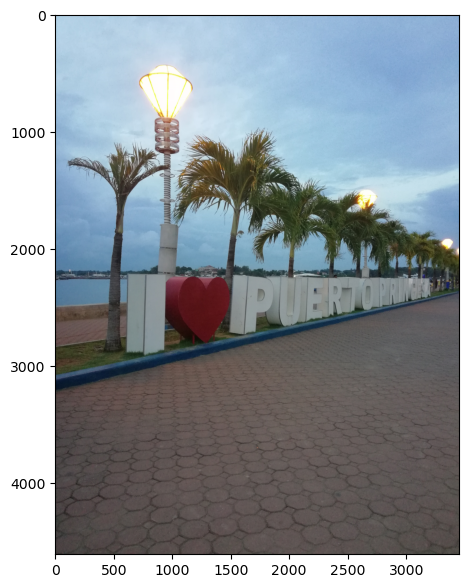

In [2]:
img = imread('images/palawan.jpg')
plt.figure(figsize=(7,7))
plt.imshow(img);

In [3]:
def project_planes(image, src, dst):
    x_src = [val[0] for val in src] + [src[0][0]]
    y_src = [val[1] for val in src] + [src[0][1]]

    x_dst = [val[0] for val in dst] + [dst[0][0]]
    y_dst = [val[1] for val in dst] + [dst[0][1]]
    
    fig, ax = plt.subplots(1,2, figsize=(13,6))
    
    new_image = image.copy() 
    projection = np.zeros_like(new_image)

    ax[0].imshow(new_image);
    ax[0].plot(x_src, y_src, 'r--')
    ax[0].set_title('Area of Interest')
    ax[1].imshow(projection)
    ax[1].plot(x_dst, y_dst, 'r--')
    ax[1].set_title('Area of Projection')
    plt.tight_layout()

In [4]:
pts_src = np.array([(500, 600),
                    (3220, 1950),
                    (3220, 2435),
                    (500, 3100)])

pts_dst  = np.array([(100, 1000),
                      (3400, 1000),
                      (3400, 2600),
                      (100, 2600)])

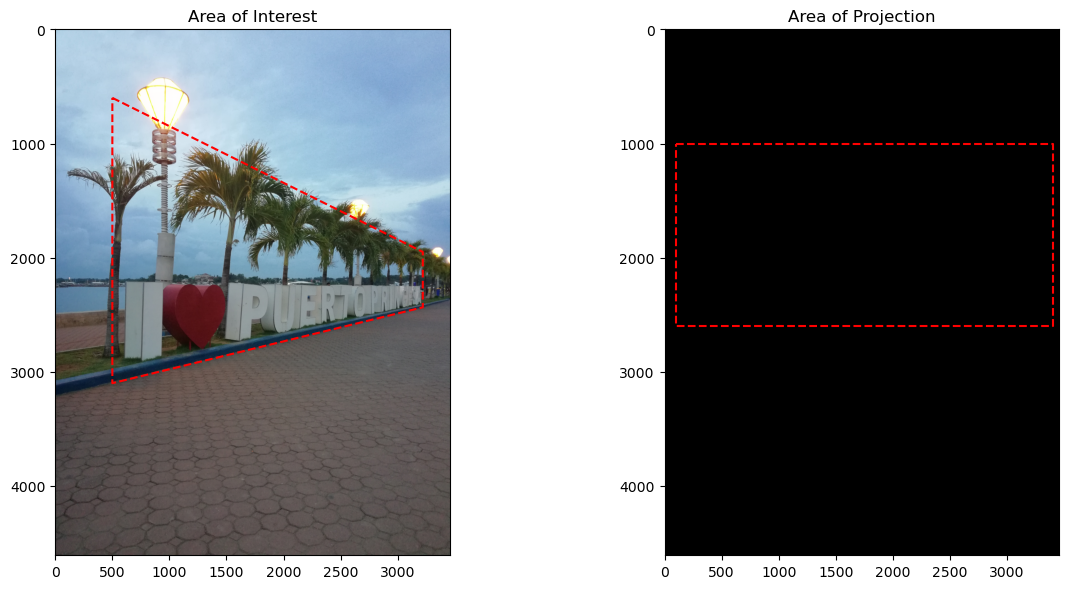

In [5]:
project_planes(img, pts_src , pts_dst)

Pour calculer une homographie entre deux plans définis par quatre points correspondants, vous pouvez utiliser l'algorithme de la Transformée Linéaire Directe (TLD). Cet algorithme trouve la matrice $H$ de taille $3 \times 3$ qui minimise l'erreur de reprojection.

Voici les étapes du processus :

1. **Formuler la Matrice d'Homographie** :

   Étant donné quatre points correspondants $P_i$ et $P'_i$ dans la première et la seconde image, respectivement, vous pouvez formuler le système d'équations :

   $$
   \begin{align*}
       x' &= \frac{h_{11}x + h_{12}y + h_{13}}{h_{31}x + h_{32}y + h_{33}} \\
       y' &= \frac{h_{21}x + h_{22}y + h_{23}}{h_{31}x + h_{32}y + h_{33}}
   \end{align*}
   $$

   Les équations d'homographie 2D peuvent être converties en un système linéaire d'équations en utilisant les coordonnées homogènes.

2. **Mettre en Place le Système Linéaire** :

   Pour chaque paire de points correspondants $P_i$ et $P'_i$, vous pouvez réécrire les équations comme suit :

   $$
   \begin{bmatrix}
       -x & -y & -1 & 0 & 0 & 0 & x'x & x'y & x' \\
       0 & 0 & 0 & -x & -y & -1 & y'x & y'y & y'
   \end{bmatrix}
   \begin{bmatrix}
       h_{11} \\
       h_{12} \\
       h_{13} \\
       h_{21} \\
       h_{22} \\
       h_{23} \\
       h_{31} \\
       h_{32} \\
       h_{33}
   \end{bmatrix}
   =
   \begin{bmatrix}
       0 \\
       0
   \end{bmatrix}
   $$

   Cela vous donne un ensemble d'équations pour les quatre points.

3. **Résoudre le Système Linéaire** :

   Cela se fait généralement à l'aide de méthodes telles que la Décomposition en Valeurs Singulières (SVD) pour trouver la solution des moindres carrés.

4. **Normaliser la Matrice d'Homographie** :

   Divisez tous les éléments de la matrice $H$ par la valeur à la position $H_{33}$ pour garantir qu'il s'agit d'une véritable matrice d'homographie.

5. **Appliquer l'Homographie** :

   Une fois que vous avez la matrice d'homographie $H$, vous pouvez l'utiliser pour transformer les points de la première image vers la seconde image, ou vice versa.

N'oubliez pas qu'en pratique, vous utiliseriez une bibliothèque telle qu'OpenCV ou similaire pour effectuer ces calculs, car elles fournissent des implémentations efficaces et précises de l'estimation de l'homographie.

In [6]:
def compute_homography(pts_src, pts_dst):
    A = []
    for i in range(4):
        x, y = pts_src[i]
        x_p, y_p = pts_dst[i]
        A.append([-x, -y, -1, 0, 0, 0, x*x_p, y*x_p, x_p])
        A.append([0, 0, 0, -x, -y, -1, x*y_p, y*y_p, y_p])
    
    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1, :].reshape(3, 3)
    H /= H[2, 2]
    
    return H




# Calculer la matrice d'homographie
H = compute_homography(pts_src, pts_dst)

In [7]:
def apply_homography(image, H):
    output_image = np.zeros_like(image)
    H_inv = np.linalg.inv(H)
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            p = np.array([x, y, 1])
            p_transformed = np.dot(H_inv, p)
            p_transformed /= p_transformed[2]
            
            x_p, y_p = int(p_transformed[0]), int(p_transformed[1])
            
            if 0 <= x_p < image.shape[1] and 0 <= y_p < image.shape[0]:
                output_image[y, x] = image[y_p, x_p]
    
    return output_image

In [8]:
# Appliquer la transformation homographie
output_image = apply_homography(img, H)

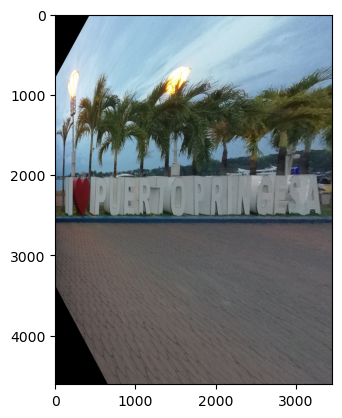

In [10]:
plt.imshow(output_image)

In [11]:
# Calculer la matrice d'homographie
H, _ = cv2.findHomography(pts_src, pts_dst)

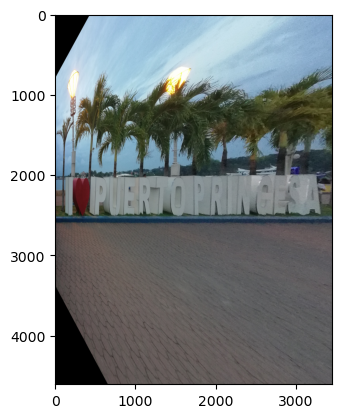

In [12]:
# Appliquer la transformation homographie
output_image = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))

plt.imshow(output_image )